# Cavity Scan Finesse3 Validation

The transmitted field from a two mirror resonator is given by Equation 2.5 in [1],

\begin{align}
a_t = a_i \frac{-t_1t_2\exp(-ikL)}{1-r_1r_2\exp(-2ikL)},
\end{align}

For transmitted amplitude $a_t$, input amplitude $a_i$, mirror amplitude reflectivities $r_1$, $r_2$ and transmissivities $t_1$, $t_2$ and resonator lenght $L$.

[1] Bond, C., Brown, D., Freise, A. et al. Living Rev Relativ (2016) 19: 3. https://doi.org/10.1007/s41114-016-0002-8

## Setup

In [1]:
maxdiff = 0
import os
import numpy as np
from matplotlib import pyplot as plt

if 'BESTDATASERVER' in os.environ:
    from bestutils import do_upload
    def display(*args,**kwargs): pass
else:
    def do_upload(*args,**kwargs): pass
    from IPython.display import display

## Test - Plane Wave, Impedance Matched, Lossless, Cavity Scan
A check that Finesse repoduces the above equation for an impedance matched cavity with several mirror transmissivities.

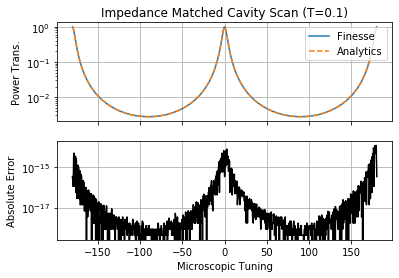

Passed impedance matched cavity test with
 T=0.1, relative diff: 2.3226380801367942e-14


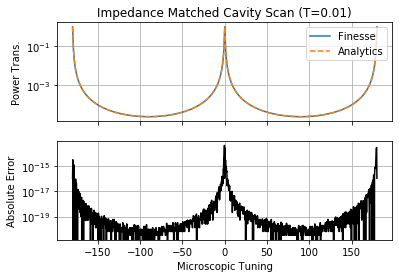

Passed impedance matched cavity test with
 T=0.01, relative diff: 1.8399975160906908e-13


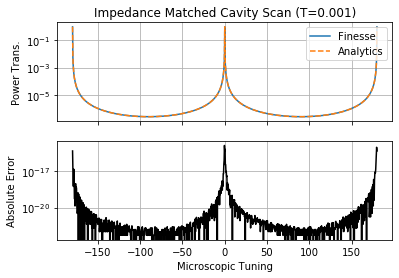

Passed impedance matched cavity test with
 T=0.001, relative diff: 2.1159121973553855e-13


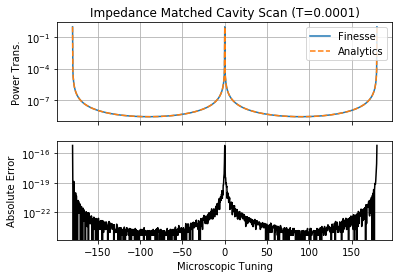

Passed impedance matched cavity test with
 T=0.0001, relative diff: 2.114158498337868e-13


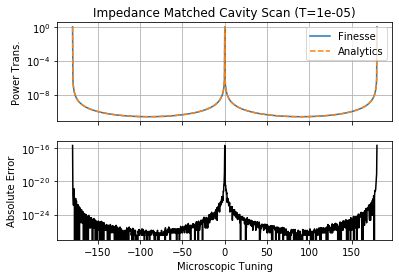

Passed impedance matched cavity test with
 T=1e-05, relative diff: 2.11993313706327e-13


In [2]:
def test_plane_wave_cavity_scan():
    import finesse
    
    for T in np.logspace(-1,-5,num=5):
        R = 1-T

        t = np.sqrt(T)
        r = np.sqrt(R)

        npoints = 1e3

        # Analytic Model
        phi = np.linspace(-np.pi,np.pi,num=int(npoints+1),
                          endpoint=True)
        at = -t*t*np.exp(1j*phi)/(1-(r*r*np.exp(2j*phi)))
        pt = np.abs(at)**2

        # Finesse Model
        kat = finesse.Model()
        kat.parse_legacy(f"""
        l laser 1 0 nLaser
        s sI 1 nLaser nIM0
        m IM {R} {T} 0 nIM0 nIM1
        s sCav 1 nIM1 nEM0
        m EM {R} {T} 0 nEM0 nEM1
        pd trans nEM1
        xaxis EM phi lin -180 180 {npoints}
        """)

        out = kat.run()
        #tuning = out.x 
        fig, ax = plt.subplots(nrows=2,sharex=True)
        ax[0].semilogy(out.x1,out['trans'],label='Finesse')
        ax[0].semilogy(180*phi/np.pi,pt,'--',label='Analytics')

        ax[1].semilogy(out.x1,np.abs(out['trans']-pt),c='k')

        ax[0].grid()
        ax[1].grid()
        ax[0].legend()
        ax[1].set_xlabel('Microscopic Tuning')
        ax[0].set_ylabel('Power Trans.')
        ax[1].set_ylabel('Absolute Error')
        ax[0].set_title(f'Impedance Matched Cavity Scan (T={T})')
        fig.savefig(f'Impedance_Matched_T{T:.6f}.png')
        display(fig)
        plt.close()
        do_upload(f'Impedance_Matched_T{T:.6f}.png')
        try:
            assert np.all(np.isclose(out['trans'],pt,
                                     rtol=1e-13,atol=1e-13))
        except AssertionError:
            print(f'Finesse does not match analytics for\n'
            f' impedance matched, lossless, cavity scan with T={T}')
            sys.exit(15)
        else:
            global maxdiff
            diff = np.max(np.abs(out['trans'] - pt)/np.abs(pt))
            maxdiff = max(maxdiff,diff)
            print(f'Passed impedance matched cavity test with\n'
                  f' T={T}, relative diff: {diff}')
test_plane_wave_cavity_scan()

# Test Mode Behaviour For a Hemispherical Cavity

The round trip Gouy phase for a cavity is given by Eq 9.64 in [1]. 
$$
\psi = 2\arccos\left(\text{sign}(B)\sqrt{\frac{A+D+2}{4}}\right),
$$
where $A, B, D$ are the ABCD matrix elements. The following is a check that Finesse reproduces a correct cavity scan with higher order modes.

            finesse.model [ WARNING]: Modal model enabled with only HG00. Call Model.select_modes to add modes.


Cavity ABCD Matrix
[[-0.875   0.0375]
 [-6.25   -0.875 ]]
Cavity g factor:
0.0625
Cavity round trip gouy phase:
151.04497562814015


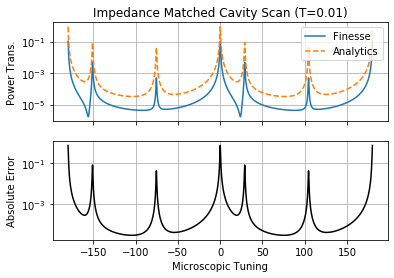

Finesse does not match analytics for impedance matched, lossless, higher order
 modes cavity scan with T=0.01 and Gouy=151.0deg


SystemExit: 15

/Users/ddb/opt/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3327: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
def test_hemispherical_cavity_scan():
    """Proxy function to scope variables"""
    
    import finesse
    
    def mirror_refl(Rc):
        return np.matrix([[1.0,0.0],[-2.0/float(Rc),1.0]])

    def space(L):
        return np.matrix([[1.0, L],[0.0,1.0]])  
    
    def get_trans_field(n,m,phi,t,r,gouy_rt):
        """
        Return the transmitted field.
        n: HG n index
        m: HG m index 
        phi: Phase gain on a single pass though the cavity 
                    (-ikL where L = lenght of cavity)
        r: Amplitude reflectivity of mirrors
        t: Amlitute transmissivity of the mirrors
        gouy_rt: round trip (two pass) gouy phase
        """
        # We do a bit of a hack here because finesse 
        # sets the cavity lenght for the 00 mode 
        # to be the resonance condition for the 00, 
        # so whilst the gouy phase is normally
        # (n+m+1) here we set it to (n+m) to account for this
        # Also here we are scanning the single lenght of the 
        # cavity phi=-ikL and the light sees this lenght twice
        # per round trip, so we need to divide the round trip
        #cavity gouy phase by two.
        phase = phi+(0.5*n*gouy_rt)+(0.5*m*gouy_rt)
        return -t*t*np.exp(1j*phase)/(1-(r*r*np.exp(2j*phase)))
    
    
    def get_gouy_rt(Rc,L):
        """Another proxy to scope variables"""
        abcd_RT = np.matmul(space(L),
                    np.matmul(mirror_refl(Rc),
                              np.matmul(space(L),
                                        mirror_refl(np.infty))))
        
        print('Cavity ABCD Matrix')
        print(abcd_RT)
        A = abcd_RT[0,0]
        B = abcd_RT[0,1]
        C = abcd_RT[1,0]
        D = abcd_RT[1,1]
        g12 =(A+D+2)/4
        print('Cavity g factor:')
        print(g12)
        gouy_RT = 2*np.arccos(np.sign(B)*np.sqrt(g12))
        print('Cavity round trip gouy phase:')
        print(180*gouy_RT/np.pi)
        return gouy_RT
    
    def do_test(Rc):
        T = 0.01
        R = 1-T

        L = 0.3 #[m]
        #Rc = 1

        P00 = 1
        P10 = 0.05
        P02 = 0.1
        # adding normalisation for TEM fields to the overall power
        # (this is how Finesse handles TEM commands)
        normalise_P_factor = 1 / np.sqrt(P00 + P10 + P02)
        npoints = 1e4

        gouy_RT = get_gouy_rt(Rc,L)
     
        # Analytic Model
        phi = np.linspace(-np.pi,np.pi,num=int(npoints+1),
                          endpoint=True)
        at00 = np.sqrt(P00)*normalise_P_factor*get_trans_field(
            0,0,phi,np.sqrt(T),np.sqrt(R),gouy_RT)
        at10 = np.sqrt(P10)*normalise_P_factor*get_trans_field(
            1,0,phi,np.sqrt(T),np.sqrt(R),gouy_RT)
        at02 = np.sqrt(P02)*normalise_P_factor*get_trans_field(
            0,2,phi,np.sqrt(T),np.sqrt(R),gouy_RT)

        pt = np.abs(at00)**2 + np.abs(at02)**2 + np.abs(at10)**2

        global kat
        # Finesse Model
        kat = finesse.Model()
        kat.parse_legacy(f"""
        l laser 1 0 nLaser
        tem laser 1 0 0.05 0
        tem laser 0 2 0.1 0
        s sI 1 nLaser nIM0
        m IM {R} {T} 0 nIM0 nIM1
        s sCav {L} nIM1 nEM0
        m EM {R} {T} 0 nEM0 nEM1
        attr EM Rc {Rc}
        pd trans nEM1
        cav c1 IM nIM1 EM nEM0
        xaxis EM phi lin -180 180 {npoints}
        maxtem 3
        """)
        out = kat.run()

        fig, ax = plt.subplots(nrows=2,sharex=True)
        ax[0].semilogy(out.x1,out['trans'],label='Finesse')
        ax[0].semilogy(180*phi/np.pi,pt,'--',label='Analytics')

        ax[1].semilogy(out.x1,np.abs(out['trans']-pt),c='k')

        ax[0].legend()
        ax[0].grid()
        ax[1].grid()
        ax[1].set_xlabel('Microscopic Tuning')
        ax[0].set_ylabel('Power Trans.')
        ax[1].set_ylabel('Absolute Error')
        ax[0].set_title(f'Impedance Matched Cavity Scan (T={T})')
        display(fig)
        fig.savefig(f'HOM_Matched_Gouy{180*gouy_RT/np.pi:.1f}.png')
        plt.close()
        do_upload(f'HOM_Matched_Gouy{180*gouy_RT/np.pi:.1f}.png')
         
        try:
            assert np.all(np.isclose(out['trans'],pt,
                                     rtol=1e-13,atol=1e-13))
        except AssertionError:
            import sys
            print(f'Finesse does not match analytics for '+
                  f'impedance matched, lossless, higher order\n'+
                  f' modes cavity scan with T={T}'+
                  f' and Gouy={180*gouy_RT/np.pi:.1f}deg')
            sys.exit(15)
        else:
            global maxdiff
            diff = np.max(np.abs(out['trans'] - pt)/np.abs(pt))
            maxdiff = max(maxdiff,diff)
            print(f'Passed impedance matched cavity test '+
                  f'with higher order modes, T={T}\n'+
                  f' and Gouy={180*gouy_RT/np.pi:.1f}deg, '+
                  f'relative differance: {diff}')
    
    for Rc in [0.32,0.4,1,3,10]:
        do_test(Rc)
test_hemispherical_cavity_scan()

In [4]:
import numpy as np
print('Max relative difference: '+str(np.max(maxdiff)))

Max relative difference: 2.11993313706327e-13
